# Imports and Data Preparation

Comparisions for RF-GAP
    - MALI
    - KEMA (MAT-LAB); wait


Some Ideas:
- Since this method requires labels, we could classiy different domains based on the labels. For example, if we have a data set of people sick with Creutzfeld-Jakob discease and the other domain is people who are sick with alzheimers. 

In [1]:
from mashspud import MASH
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma
from mashspud import SPUD
from rfgap import RFGAP
import matplotlib.pyplot as plt


#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="iris.csv", split = "distort", percent_of_anchors= [0.2], verbose = 2, random_state= 42)

2024-10-31 10:01:16.775189: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-31 10:01:16.776942: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 10:01:16.780436: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-31 10:01:16.791154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 10:01:16.808960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

MDS initialized with 4 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [2]:
def use_rf_proximities(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

        #Change known_anchors to correspond to off diagonal matricies -- We have to change this as its dependent upon A
        self.known_anchors_adjusted = np.vstack([self.known_anchors.T[0], self.known_anchors.T[1] + self.len_A]).T

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 1

    return 1 - dataA

# Applying RF GAP for SPUD

In [3]:
#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = use_rf_proximities, distance_measure_B= use_rf_proximities, knn = 12, agg_method = "log", OD_method="default", verbose = 4)

#Fit SPUD
spud_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:12])

Time it took to compute SGDM:  0.33
Time it took to execute graphtools.Graph functions:  0.16
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.01
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


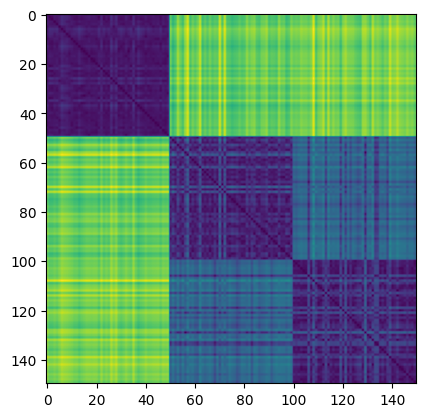

In [4]:
plt.imshow(spud_class.block[spud_class.len_A:, :spud_class.len_A])


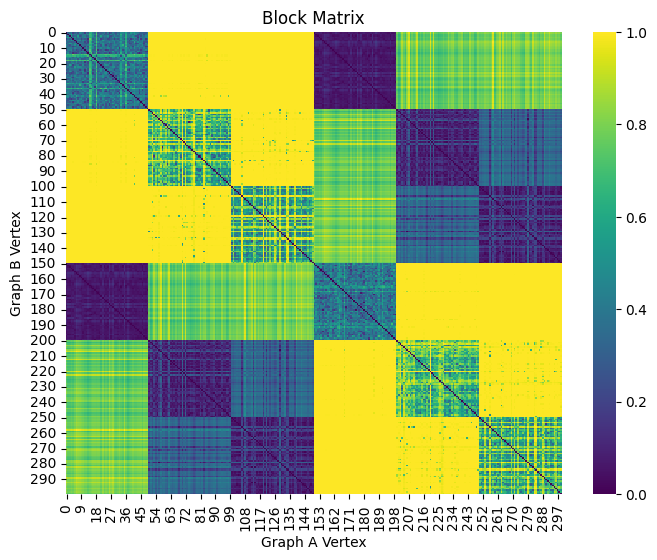

In [5]:
spud_class.plot_heat_map()

Time it took to calculate the embedding: 0.52
Calculating the classification Score.
Cross Embedding score: 0.9833333333333334
Fraction of Samples Closest to thier Match: 0.00017777777777777779


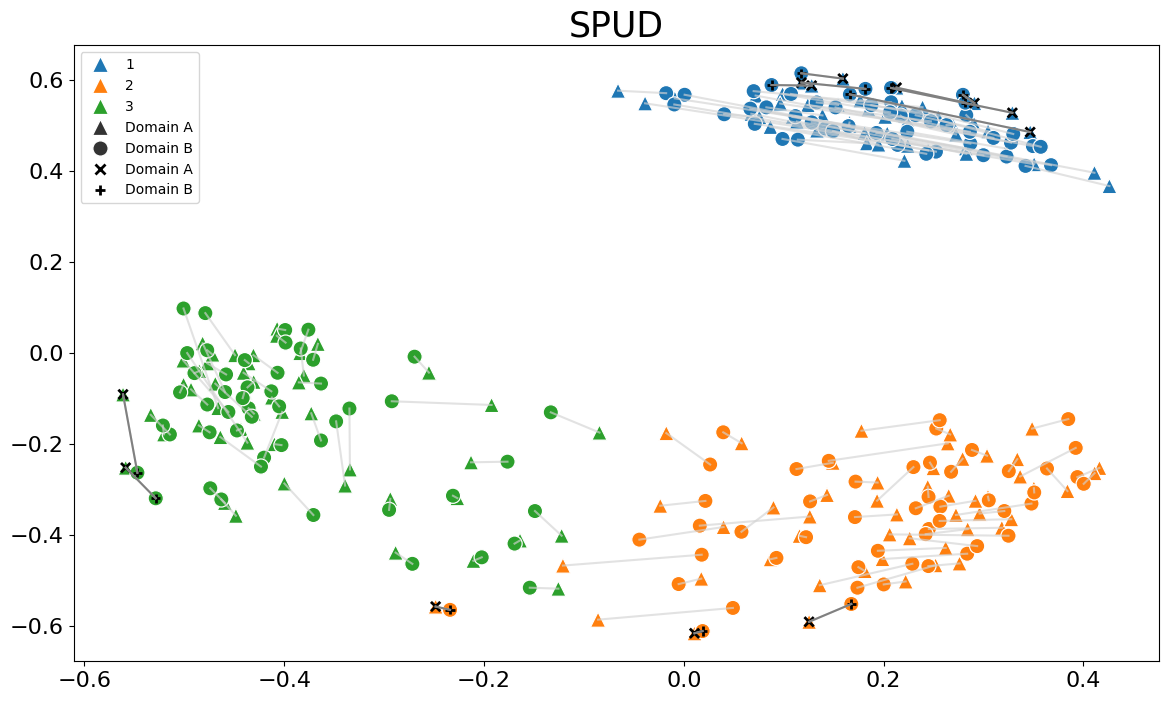

Time it took complete the plots: 0.35


In [6]:
spud_class.plot_emb(labels = dc.labels_doubled, show_lines = True, show_anchors = True)

# Applying RF GAP for MASH

In [7]:
#Create an RF Proximities function
def use_rf_proximities_MASH(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True) #Change Classification to regression

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 1

    return 1 - dataA

In [8]:
old = dc.anchors

In [9]:
#Initialize SPUD Class
mash_class = MASH(distance_measure_A = use_rf_proximities_MASH, distance_measure_B= use_rf_proximities_MASH, knn = 8, verbose = 3, DTM = "log")

#Fit SPUD
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:4])

Time Data Below
 Time it took to execute SGDM for domain A:  0.16077
 Time it took to execute the graph for domain A:  0.00134
 Time it took to execute SGDM for domain B:  0.16218
 Time it took to execute the graph for domain B:  0.00151
 Time it took to compute merge_graphs function:  0.01979
 Time it took to compute similarity_matrix function:  0.00026
Using optimal t value of 6
 Time it took to compute diffusion process:  0.0346
Fit process finished. We recommend calling optimize_by_creating_connections.


In [10]:
(dc.anchors.all == old.all)

True

Time it took to calculate the embedding: 0.22452
Calculating the classification Score.
Cross Embedding score: 0.6666666666666666
Fraction of Samples Closest to thier Match: 0.2255111111111111


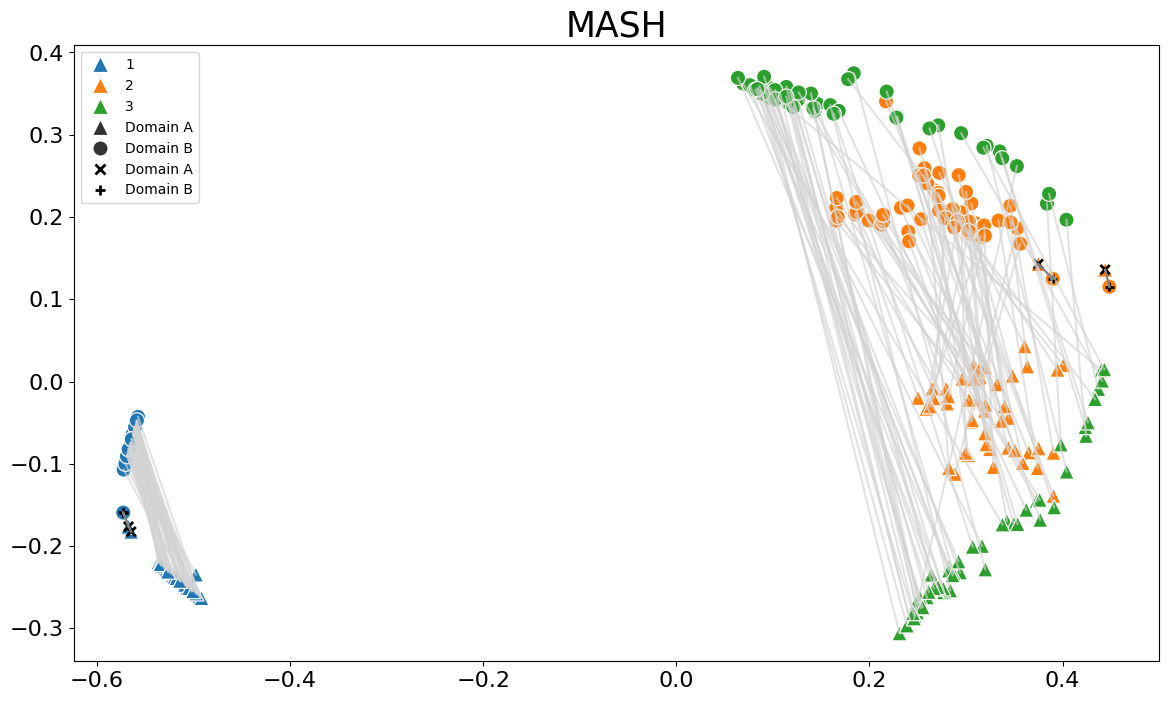

In [11]:
mash_class.plot_emb(labels = dc.labels_doubled)

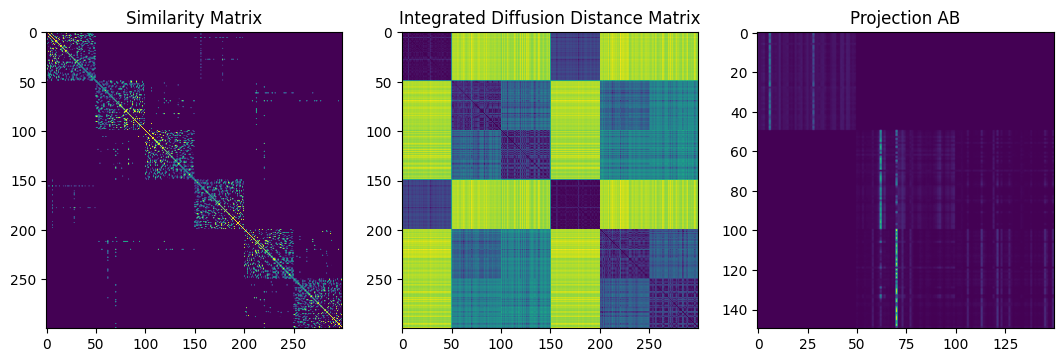

In [12]:
mash_class.plot_heat_maps()

Time Data Below
 Time it took to execute the graph for domain A:  0.08333
 Time it took to compute kernal A:  0.0001
 Time it took to execute the graph for domain B:  0.07025
 Time it took to compute kernal B:  0.00011
 Time it took to compute merge_graphs function:  0.0185
 Time it took to compute similarity_matrix function:  0.00022
Using optimal t value of 21
 Time it took to compute diffusion process:  0.02853
Fit process finished. We recommend calling optimize_by_creating_connections.


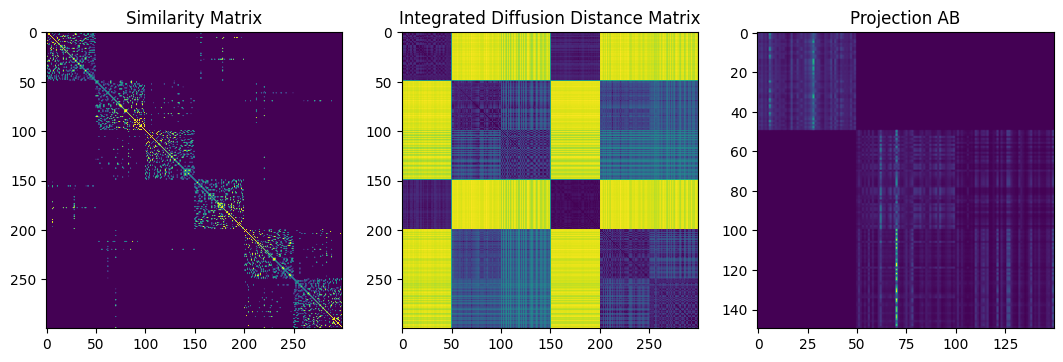

In [13]:
#Initialize SPUD Class
mash_class2 = MASH(knn = 8, verbose = 3, DTM = "log")
mash_class2.fit(dataA = dc.split_A, dataB = dc.split_B, known_anchors = dc.anchors[:4])
mash_class2.plot_heat_maps()

Time it took to calculate the embedding: 0.21187
Calculating the classification Score.
Cross Embedding score: 0.6666666666666666
Fraction of Samples Closest to thier Match: 0.2477333333333333


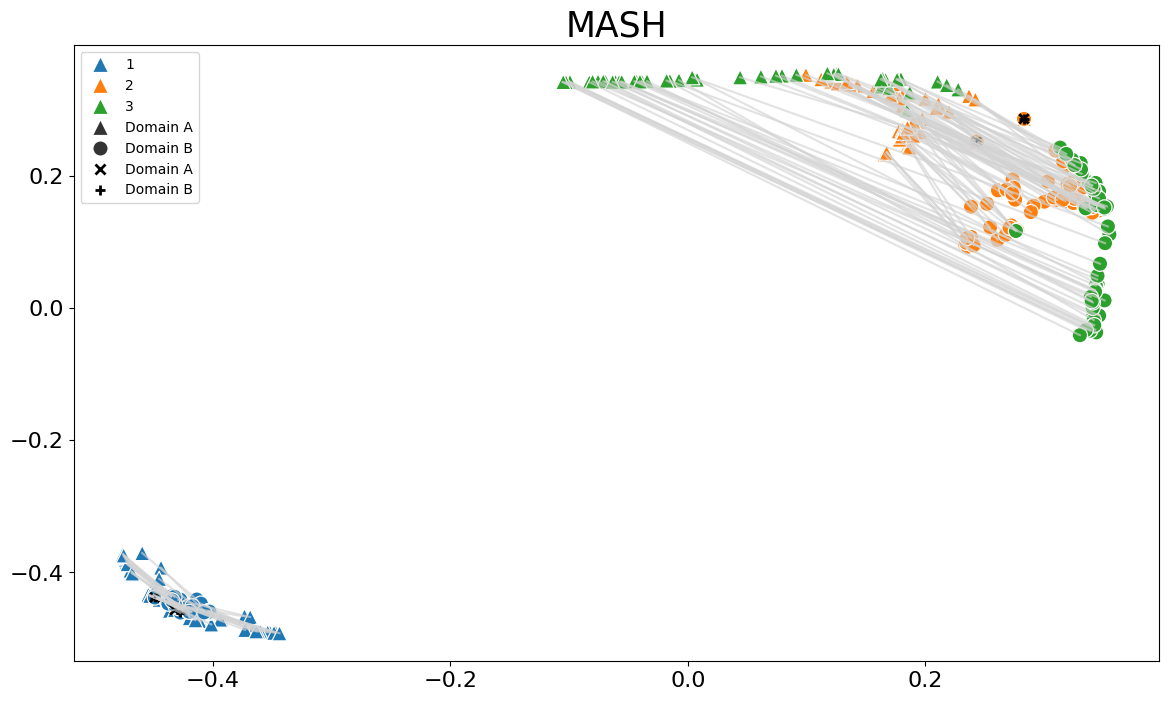

In [14]:
mash_class2.plot_emb(labels = dc.labels_doubled)

<><><><><> Beggining Tests. Original Connections show below <><><><><>


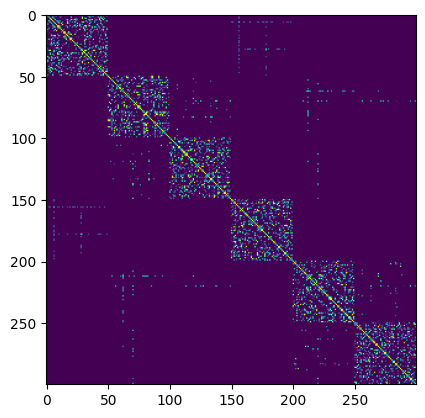

Edges wont be set with similarity measure above: 0.91
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 5330
New connections found: 30


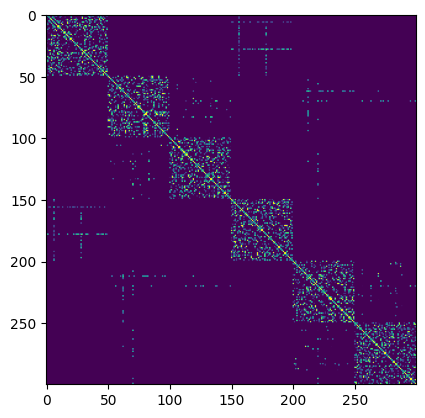

Using optimal t value of 25
The new connections worsened the alignment by 0.034999999999999976
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 5330
New connections found: 30


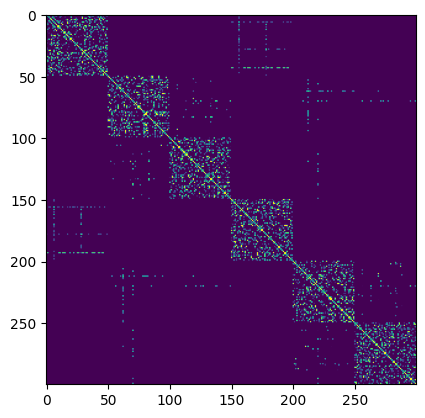

Using optimal t value of 26
The new connections worsened the alignment by 0.05250000000000005
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 2    <><><><><><><><><><><><><>
Total number of Known_connections: 5330
New connections found: 30


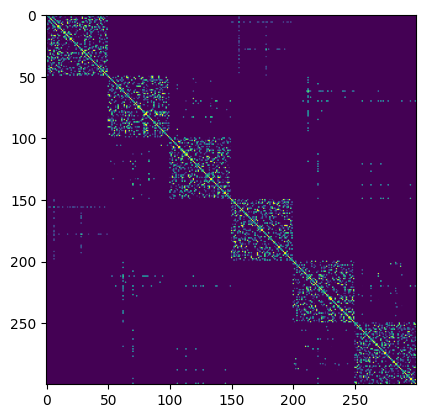

Using optimal t value of 35
The new connections improved the alignment by 0.03916666666666668
-----------     Keeping the new alignment. Continuing...    -----------

Using optimal t value of 12
Added Hold Out Anchor Conections


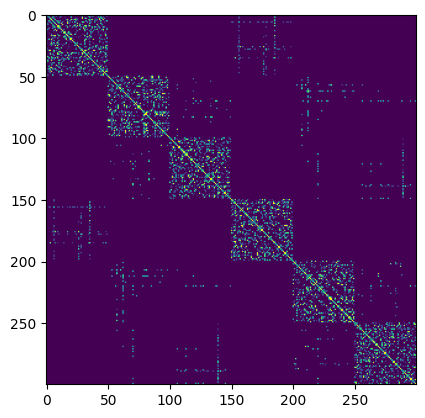

<><><><><><><><><><<><><><><<> Epochs Finished <><><><><><><><><><><><><><><><><>


True

In [15]:
mash_class.optimize_by_creating_connections(epochs=3, connection_limit= 30, threshold = 0.9, hold_out_anchors=dc.anchors[4:8])

Calculating the classification Score.
Cross Embedding score: 0.6666666666666666
Fraction of Samples Closest to thier Match: 0.14955555555555552


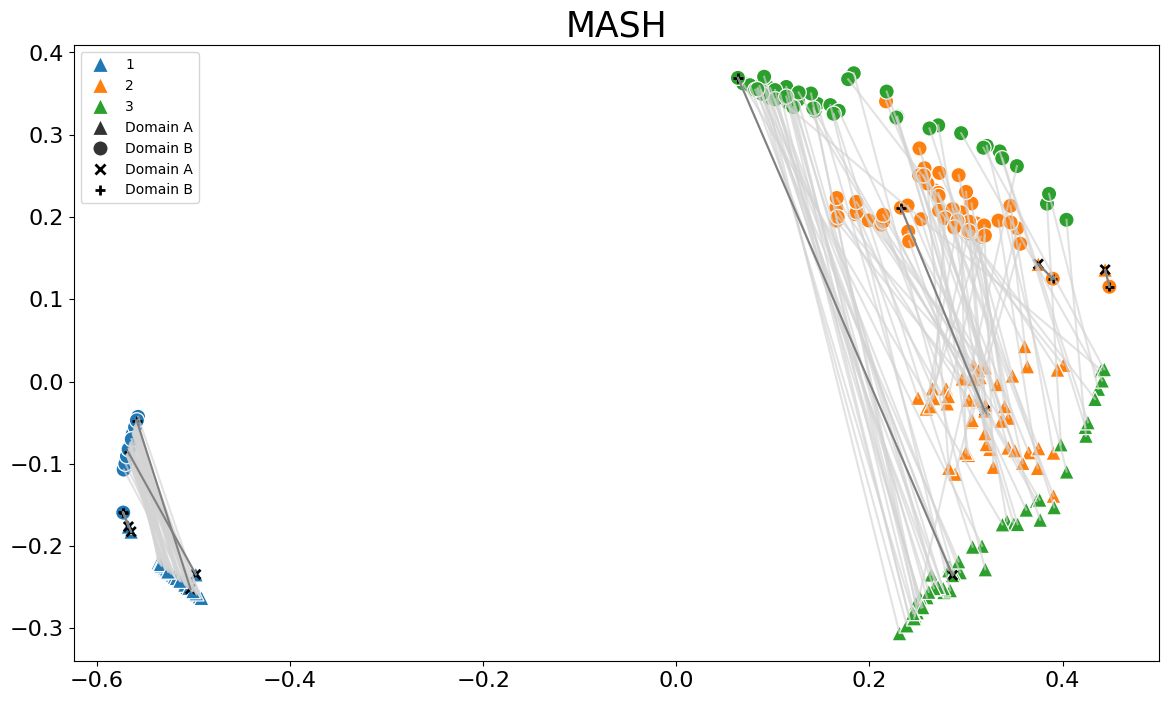

In [16]:
mash_class.plot_emb(labels = dc.labels_doubled)